# Homework 1

by Erik Webb

## Dataset 1: API

### Gathering the Data

Since I had already worked with data in .txt and .csv formatts, I first wanted to retrive data via an api. From the [list](https://github.com/toddmotto/public-apis) of public APIs collected by Github user 'toddmotto', I selected the [iex](https://iextrading.com/developer/docs/#quote) financial data API. I then leveraged the [code](https://github.com/himoacs/iex_data/blob/master/iex_data.py) written by github user 'himoacs' to retrieve fiancial data about 10 technology companies.

In [ ]:
import pandas as pd
from urllib.request import Request, urlopen
import json
from pandas.io.json import json_normalize

In [ ]:
# The cell below contains the code to create the class 'API'.

class API(object):

    def __init__(self):
        self._end_point_prefix = r'https://api.iextrading.com/1.0/'

    def return_valid_securities(self, securities):
        suffix = r'ref-data/symbols'
        valid_securities = self._url_to_dataframe(self._end_point_prefix+suffix)['symbol']
        return [x for x in securities if x in set(valid_securities)]

    def _url_to_dataframe(self, url, nest=None):
        request = Request(url)
        response = urlopen(request)
        elevations = response.read()
        data = json.loads(elevations)

        if nest:
            data = json_normalize(data[nest])
        else:
            data = json_normalize(data)

        return pd.DataFrame(data)

    def get_financials(self, securities):
        securities = self.return_valid_securities(securities)
        final_df = pd.DataFrame({})

        # Get financials of each security and then append the results together
        if securities:
            for symbol in securities:
                suffix = r'stock/{symbol}/financials'.format(symbol=symbol)
                df = self._url_to_dataframe(self._end_point_prefix + suffix, 'financials')
                df['symbol'] = symbol
                final_df = final_df.append(df, ignore_index=True)
            return final_df
        else:
            print('These stock(s) are invalid!')

I used the get_financials() function to obtain four quarters worth of financial data about the first ten technology companies to come to mind. The companies, in order, were:
- Apple 
- Google
- Facebook
- Amazon
- Microsoft
- Intel
- IBM
- HP
- Cisco Systems
- Oracle

In [ ]:
m = API()
ticker_list = ['AAPL', 'GOOGL', 'FB', 'AMZN', 'MSFT', 'INTC', 'IBM', 'HPE', 'CSCO', 'ORCL']
fin_df = pd.DataFrame(m.get_financials(ticker_list))

As you can see below, the data consists of accounting measures typically reported by publicly-traded companies. For exampe: revenue, assets, liabilities, operating expesne, gross profit, and net income.  

In [ ]:
fin_df[fin_df['symbol']=='AAPL']

### Cleaning the Data

I first converted the 'reportDate' variable from a non-null object to a non-nul datetime64 object.

In [ ]:
fin_df['reportDate'] = pd.to_datetime(fin_df['reportDate'])

Next, I examinded the data for missing values. 

In [ ]:
fin_df.isnull().any()

The following variables were missing data from the following companies:

- operatingGainsLosses: AAPL, FB, AMZN, ORCL
- currentDebt: GOOGL, FB, AMZN, ORCL
- totalDebt: GOOGL (3/4 Quarters), FB, AMZN

Why are these data missing? I noticed that some of the 'missing' values said 'None' while others said 'NaN'. The cultript companies seem to be the younger or relativily newer companies (FB, AMZN, FB) compared to companies who have been around for decades (IBM, MSFT). I'll proceed with the analysis without focusing on the variables with missing values: operatingGainsLosses, currentDebt, and totalDebt. 

### Analyzing the Data

There are a couple of questions worth exploring in this small, but interesting dataset. Here are two:

1. Which firms achieved the highest average revenue across the four quarters represented?
2. What's the relationship between the amount of assets a technology company has and the amount of total revenue they generate.

I'll use these questions as starting points for further data exploration and analysis. 

In [ ]:
#fin_df.describe()
#fin_df.corr()

Let's start off by looking at average total reveneue in descending order.

In [ ]:
fin_pivot_table_tr = pd.pivot_table(fin_df, values = 'totalRevenue', index = ['symbol'], aggfunc = np.mean)
fin_pivot_table_tr = fin_pivot_table_tr.rename(index=str, columns={"totalRevenue": "Avg Total Revenue"})
fin_pivot_table_tr.sort_values(by = ['Avg Total Revenue'], ascending = False)

Apple is the clear winner, with \$57,308,500,000 in average total revenue, followed by Amazon and Google. Interesting to note these companies are generating more average revenue than older companies like Microsoft, IBM, and Oracle. I was surprised to see Facebook in second-to-last place, although \$9 billion in average total revenue is obviously not trivial. 

What if we considered average _net income_ across the four quarters instead of average total revenue? Isn't the bottom line what shareholders and executives alike ultimately care about?

In [ ]:
fin_pivot_table_ni = pd.pivot_table(fin_df, values = 'netIncome', index = ['symbol'], aggfunc = np.mean)
fin_pivot_table_ni = fin_pivot_table_ni.rename(index=str, columns={"netIncome": "Avg Net Income"})
fin_pivot_table_ni.sort_values(by = ['Avg Net Income'], ascending = False)

Apple comes in first place again, with a staggering \$12,087,750,000 in average net income. That's as much as the GDP of a small [country](http://statisticstimes.com/economy/countries-by-projected-gdp.php)! Facebook jumped from 9th place to 4th place in terms of average net income. Amazon on the other hand dropped from 2nd to 9th place! I guess margins have always been slim in retail. 

Let's next consider the average profit margin, expressed as a percentage. Profit margin is a profitability ratio calculated as net income divided by revenue. Simply put, it tells us how many pennies of profit a company recieves for every $1 of revenue generated. 

In [ ]:
fin_pivot_table = pd.merge(fin_pivot_table_tr, fin_pivot_table_ni, left_index=True, right_index=True)
fin_pivot_table['Avg Profit Margin'] = fin_pivot_table['Avg Net Income']/fin_pivot_table['Avg Total Revenue']
fin_pivot_table.sort_values(by = ['Avg Profit Margin'], ascending = False)

Facebook now leads the pack, earning a stunning 42 cents for every $1 of revenue generated. That's about 1.5x more than the company with the next highest average profit margin, Oracle, with a profit margin of ~25%. After evaluting these metrics, I think one takeaway is that there are many ways to define success. For example, Facebook may have generated less average revenue that other top technology firms, but it's brining home a greater portion of those funds as net income. 

To anwser the second question, I then examined the relationship between the total amount of assets held by a technology company and the amount of revenue they were able to generate in a given fiscal quarter.

I began by calculating the correlation coefficient:

In [ ]:
fin_df['totalAssets'].corr(fin_df['totalRevenue'])

With a value of .70, there appears to be a relativly strong relationship between these two variables. Creating a scatterplot helped to further illustrate the relationship. 

In [ ]:
sns.lmplot(x="totalAssets", y="totalRevenue", data=fin_df)
plt.show()

As expected, the scatterplot demonstrated that (generally speaking) a larger amount of assets is correlated with a larger amount of revenue. The fitted line seems to fit the data somewhat well, with the exception of the cluster of data points where a relativily large amount of revenue was generated with a relativly small amount of assets. In subsequent analysis, I would be interested in determining what properties/attributes/features of that particular technology company allowed it accomplish that feat.

This analysis was clearly simplisitc but I thought it explored two interesting questions and provided a good exercise in extracting data via API calls. 

## Dataset 2: CSV

### Gathering the Data

My wife teaches English to children in China online through a platform called VIPKID. Despite the very early mornings (Beijing is 15 hours ahead of Utah), she enjoys her job. 

The platform provides a record of all the lessons she has taught, which are always 25 minutes in length. For each record, there is data about the lesson time, the lesson id/name, the finish type, if the lesson was booked on short notice, and the amount earned by teaching the lesson. 

I manually compiled 8 months of this information into a Google Spreadsheet and downloaded the data as a CSV file for analysis in Python. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
vip_df = pd.read_csv("/Users/erikgregorywebb/Downloads/VIPKID_Raw.csv")
vip_df.head()

In [ ]:
vip_df.info()

### Cleaning the Data

To prepare for analysis, I wanted to ‘clean’ the data and ensure I was using the correct data types for each of the variables. For example, I converted the lesson date stamp variable (originally a series of strings called 'Time') into two seperate datetime objects: Date and Time. 

In [ ]:
# Turn the 'Time' variable (which actually includes both date AND time) into seperate 'Date' and 'Time' variables
vip_df['Date'] = ""
for i in range(0, len(vip_df)):
    vip_df.loc[i, 'Date'] = datetime.strptime(vip_df.loc[i, 'Time'], "%m/%d/%Y %H:%M:%S").date()
    vip_df.loc[i, 'Time'] = datetime.strptime(vip_df.loc[i, 'Time'], "%m/%d/%Y %H:%M:%S").time()

Next, I created additional variables by extracting pieces of information from existing variables. For example, I extracted the name of the month as well as the day of the week from the lesson date stamp. From the lesson ID I created a variable indicating if the lesson was a ‘major course’ or a ‘trail lesson’, the two broadest lesson categories. 

In [ ]:
# Rearrange the columns in the name of order
cols = vip_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
vip_df = vip_df[cols]

In [ ]:
vip_df['Category'] = ""
vip_df['Month'] = ""
vip_df["DOW"] = ""

for i in range(0, len(vip_df)):
    vip_df.loc[i, 'Category'] = vip_df.loc[i, 'Lesson_ID'][:2]
    vip_df.loc[i, 'Month'] = vip_df.loc[i, 'Date'].strftime("%m/%Y")
    vip_df.loc[i, 'DOW'] = vip_df.loc[i, 'Date'].strftime("%w")

In [ ]:
vip_df.head()

### Analyzing the Data

With the cleaning and variable manipulation complete, I began my analysis. Although there are several ways to potentially slice and analyze the data, I determined to answer the following four questions:

1. How much money has my wife earned each month for the past 8 months?
2. How has the distribution of lesson finish type changed over time?
3. How has the distribution of major course and trial lessons changed over time?
4. What is the distribution of lesson counts across day of the week and time of day?

#### 1. How much money has my wife earned each month for the past 8 months?

In [ ]:
vip_pivot_table = pd.pivot_table(vip_df, values = 'Payment', index = ['Month'], aggfunc = np.sum)
vip_pivot_table

In [ ]:
print(sum(vip_pivot_table['Payment']))

It appears that my wife earned the most during the early summer months and then earned less in the Fall when she began working a second job. The month with the highest earned income was June 2017, with a total payment of $1,422.25. 

To date, she has earned a total of $6,187.25. 

#### 2. How has the distribution of lesson finish type changed over time?

In [ ]:
vip_crosstab = pd.crosstab(vip_df['Month'], vip_df['Finish_Type'])
vip_crosstab

This crosstab shows the count of lessons organized by month and finish type. To make a more accurate comparison of how the distribution of lesson finish types have changed over time, I calculated the value of each cell to be its percentage of the row total.

In [ ]:
vip_crosstab_percentage = vip_crosstab.apply(lambda x: x/x.sum(), axis=1)
vip_crosstab_percentage

In [ ]:
vip_crosstab_percentage.plot()
plt.show()

This revised crosstab (and chart) demonsrate that the distribution of lesson finish types remained fairly constant over the 8 month period. 

#### 3. How has the distribution of major course and trail lessons changed over time?

In [ ]:
vip_category = pd.pivot_table(vip_df, values = 'Payment', index = ['Month'], columns = ['Category'], aggfunc = 'count')

In [ ]:
N = len(vip_category)
ind = np.arange(N)
Major = vip_category['MC']
Trial = vip_category['T1']
width = 0.35

p1 = plt.bar(ind, Major, width, color='#d62728')
p2 = plt.bar(ind, Trial, width,
             bottom=Major)

plt.ylabel('Lessons Taught')
plt.xlabel('Month')
plt.title('Major vs. Trial Lessons Over Time')
plt.xticks(ind, ('5/17', '6/17', '7/17', '8/17', '9/17', '10/17', '11/17', '12/17'))
plt.legend((p1[0], p2[0]), ('Major', 'Trial'))
plt.show()

The stacked bar chart above shows that there is more variation in the distribution of major vs. trial lessons over time than there is distribution in lesson finish type. For example, in August trial classes were a much smaller proportion of the total number of lessons taught compard to the month of October. 

#### 4. What is the distribution of lesson counts across day of the week and time of day?

In [ ]:
vip_heatmap = pd.pivot_table(vip_df, values = 'Payment', index = ['Time'], columns = ['DOW'], aggfunc = 'count')
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(vip_heatmap, annot = True, linewidths=.5, ax=ax)
plt.show()

In the heatmap above, the Day of the Week (DOW) axixs begin with 0 (Sunday) and ends with 6 (Saturday). There appears to be a high concentration of lessons taught weekdays during the early hours of morning, between 4:30 and 7:00 am. The most frequest lesson day of the week and time has been Friday at 6 am.

## Dataset 3: Web Scraping

### Gathering the Data

Are NBA players getting bigger? Taller? Heavier? That was my question of interest when I scrapped basketball-reference.com. This website has a page of current and former NBA players by last name for each letter of the alphabet, except x.

I wrote a piece of code that looped through each page and scrapped the player data.  

In [1]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import  pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
import time

In [2]:
letters = list(string.ascii_lowercase)
letters.remove("x")

df = pd.DataFrame()
for letter in letters:
    time.sleep(1)
    scrape_url = "https://www.basketball-reference.com/players/{}/".format(letter)
    r = requests.get(scrape_url)
    soup = BeautifulSoup(r.content, "lxml")
    data = ""
    for tr in soup.find_all("tr"): 
        record = "" 
        for td in tr.find_all(["th", "td"]): 
            record = record + "|" + td.text 
        if len(record)!=0:
            data = data + "\n" + record[1:]
    readable_data = pd.compat.StringIO(data)
    bb = pd.read_table(readable_data, sep="|")
    df = df.append(bb)
bb_df = df

The resulting dataframe looks like this:

In [4]:
bb_df.head()

,Player,From,To,Pos,Ht,Wt,Birth Date,College
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar*,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [5]:
len(bb_df)

4556

I now had information about 4,000+ players including when the started and ended playing in the league, their position, height, weight, birth date, and the college they attended.

### Cleaning the Data

I started the cleaning process by using the describe() function and seeing what variables had missing values.

In [6]:
bb_df.describe()

,From,To,Wt
count,4556.000000,4556.000000,4550.000000
mean,1985.119622,1989.313652,208.911868
std,20.994358,21.889357,26.262309
min,1947.000000,1947.000000,114.000000
25%,1969.000000,1973.000000,190.000000
50%,1986.500000,1992.000000,210.000000
75%,2003.000000,2009.000000,225.000000
max,2018.000000,2018.000000,360.000000


In [7]:
bb_df.isnull().any()

Player        False
From          False
To            False
Pos            True
Ht             True
Wt             True
Birth Date     True
College        True
dtype: bool

In [9]:
bb_df = bb_df.dropna(how='any')
len(bb_df)

4220

Everything looks normal for the 'From', 'To' and 'Wt' variables. The dataset includes players who played between 1947 and 2018. The average weight is 208 pounds, the minimum is 114 pounds and the maximum is 360 pounds. For the sake of simplicity, I droped rows with any missing values. This reduced my sample by 336. 

I also noticed that I needed to work with the 'Ht' (height) variable. Since it was read in as a string, I turned it into an 'inches' integer variable. Pieces of the code below were adapted from Tyler's offensive tackle football [example](https://github.com/tfolkman/learningwithdata/blob/master/Top_Offensive_Tackles.ipynb), although I had already scraped this data and begun my analysis before Tyler shared the example.

In [10]:
hgt_str = bb_df.Ht.values
hgt_str = [x.split("-") for x in hgt_str]
hgt_in = [(int(x[0]) * 12) + int(x[1]) for x in hgt_str]
se = pd.Series(hgt_in)
bb_df.insert(loc = 8, column= 'Inches', value = se)

### Analyzing the Data

With the data cleaned, I was ready to explore my question(s) of interest. 
- Are basketball players getting taller? 
- Are they getting bigger?

I created a pivot table which calculated the average player height and weight by year and plotted the results:

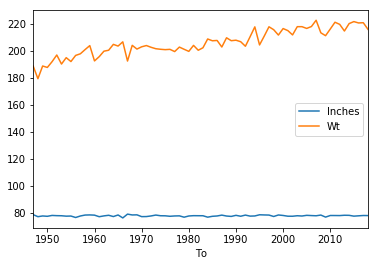

In [12]:
bb_pivot_table = pd.pivot_table(bb_df, values = ["Inches", "Wt"], index = ['To'], aggfunc = np.mean)
bb_pivot_table.plot()
plt.show()

Interesting! It appears that on average, players have become _heavier_ but not taller! By how much?

In [33]:
bb_pivot_table.iloc[[0, -1]]

,Inches,Wt
To,,
1947,78.782051,188.730769
2018,78.093827,215.960494


Between 1947 and 2018, the average player weight increased almost 15%, by 27 pounds. By contrast, the average hieght stayed almost identical.

Again, this represents the average height and weight. What about the mininum or maximum?

In [39]:
bb_pivot_table_min = pd.pivot_table(bb_df, values = ["Inches", "Wt"], index = ['From'], aggfunc = np.min)
bb_pivot_table_max = pd.pivot_table(bb_df, values = ["Inches", "Wt"], index = ['From'], aggfunc = np.max)
bb_pivot_table_2 = pd.merge(bb_pivot_table_min, bb_pivot_table_max, left_index=True, right_index=True)

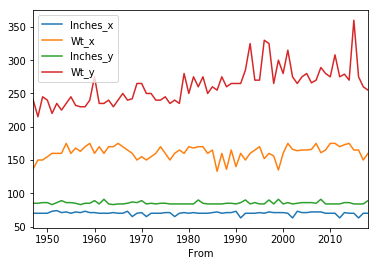

In [40]:
bb_pivot_table_2.plot()
plt.show()

Similiar trends were observed. 

Finally, what does the updward trend in player weight look like when segmented by player position? Below is a pivot table with player positions by count.

In [65]:
pivot_table_pos_count = pd.pivot_table(bb_df, values = ['Wt'], index = ['Pos'], aggfunc = 'count')
pivot_table_pos_count['pct'] = pivot_table_pos_count.Wt / pivot_table_pos_count.Wt.sum()
pivot_table_pos_count.sort_values(by = ['pct'], ascending = False)

,Wt,pct
Pos,,
G,1505,0.356635
F,1203,0.285071
C,406,0.096209
F-C,361,0.085545
G-F,336,0.079621
F-G,206,0.048815
C-F,203,0.048104


Close to 35% of players are guards, 28% are forwards, 9% are guards, and 26% are some combination. Once  I had a good idea of how positions were distributed among the players, I wanted to know how position was related to weight and how average weight had changed over time by position.

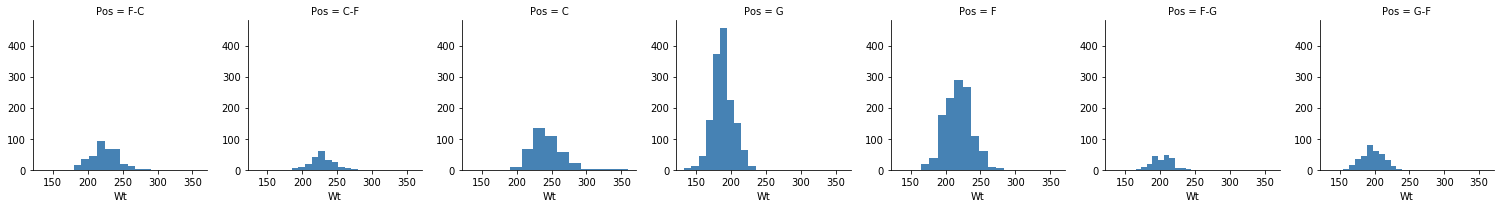

In [61]:
g = sns.FacetGrid(bb_df, col="Pos", margin_titles=True)
g.map(plt.hist, "Wt", color="steelblue")
plt.show()

In [69]:
pd.pivot_table(bb_df, values = ["Wt"], index = ['Pos'], aggfunc = np.mean).sort_values(by = ['Wt'], ascending = False)

,Wt
Pos,
C,242.219212
C-F,228.256158
F-C,222.939058
F,217.999169
F-G,202.592233
G-F,197.017857
G,186.867774


As a whole, centers are the heaviest, followed by forwards and guards. How has the average weight of these positions changed over time?

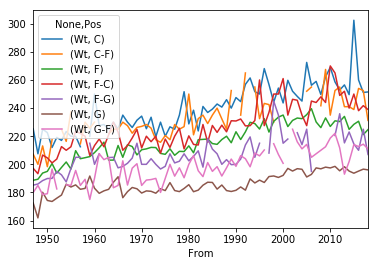

In [79]:
bb_pivot_table_pos = pd.pivot_table(bb_df, values = ["Wt"], index = ['From'], columns = ['Pos'], aggfunc = np.mean)
bb_pivot_table_pos.plot()
plt.show()

It appears that on average, players from all positions have become heavier, although the change looks most puncuated for centers. I had a lot of fun with this analysis, thanks for reading!

## Appendix

The links below proved very useful as I learned to get, clean, and visualize data in Python.

- https://docs.python.org/2/library/datetime.html
- http://www.pythonforbeginners.com/basics/python-datetime-time-examples
- https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns
- https://stackoverflow.com/questions/31481803/compute-percentage-for-each-row-in-pandas-dataframe
- https://matplotlib.org/examples/pylab_examples/bar_stacked.html
- https://stackoverflow.com/questions/39815646/pandas-append-dataframe-to-another-df
- https://stackoverflow.com/questions/12142133/how-to-get-first-element-in-a-list-of-tuples

Git Notes
1. cd Documents
2. cd Python
3. cd machine-learning
4. git status
5. git add Homework-1.ipynb
6. git commit -m "latest changes"
7. git push
8. git status